In [31]:
import ipywidgets as widgets
import sys
from pathlib import Path
import os
import importlib


module_path='preprocessing/day_intervals_preproc'
if module_path not in sys.path:
    sys.path.append(module_path)

module_path='utils'
if module_path not in sys.path:
    sys.path.append(module_path)
    
module_path='preprocessing/hosp_module_preproc'

if module_path not in sys.path:
    sys.path.append(module_path)
    
module_path='model'
if module_path not in sys.path:
    sys.path.append(module_path)
    
#print(sys.path)
root_dir = os.path.dirname(os.path.abspath('UserInterface.ipynb'))
#data_dir = '/datasets/MIMIC-IV/physionet.org/files'
data_dir='~/physionet.org/files'
import day_intervals_cohort
from day_intervals_cohort import *

import day_intervals_cohort_v2
from day_intervals_cohort_v2 import *

import data_generation_icu

import data_generation
import evaluation

import feature_selection_hosp
from feature_selection_hosp import *

# import train
# from train import *


import model.ml_models as ml_models
from ml_models import *

import dl_train
from dl_train import *

import tokenization
from tokenization import *


import behrt_train
from behrt_train import *

import feature_selection_icu
from feature_selection_icu import *
import fairness
import callibrate_output

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/h/opent03/.conda/envs/los2/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_7841/3916401465.py", line 47, in <module>
    import model.ml_models as ml_models
  File "/fs01/home/opent03/los-prediction/pipeline/model/ml_models.py", line 21, in <module>
    from imblearn.over_sampling import RandomOverSampler
  File "/h/opent03/.conda/envs/los2/lib/python3.9/site-packages/imblearn/__init__.py", line 52, in <module>
    from . import (
  File "/h/opent03/.conda/envs/los2/lib/python3.9/site-packages/imblearn/combine/__init__.py", line 5, in <module>
    from ._smote_enn import SMOTEENN
  File "/h/opent03/.conda/envs/los2/lib/python3.9/site-packages/imblearn/combine/_smote_enn.py", line 13, in <module>
    from ..over_sampling import SMOTE
  File "/h/opent03/.conda/envs/los2/lib/python3.9/site-packages/imblearn/over_sampling/__init__.py

In [30]:
!pip install imbalanced-learn

In [26]:
%load_ext autoreload
%autoreload 2

importlib.reload(day_intervals_cohort)
import day_intervals_cohort
from day_intervals_cohort import *

importlib.reload(day_intervals_cohort_v2)
import day_intervals_cohort_v2
from day_intervals_cohort_v2 import *

importlib.reload(data_generation_icu)
import data_generation_icu
importlib.reload(data_generation)
import data_generation

importlib.reload(feature_selection_hosp)
import feature_selection_hosp
from feature_selection_hosp import *

importlib.reload(feature_selection_icu)
import feature_selection_icu
from feature_selection_icu import *

importlib.reload(tokenization)
import tokenization
from tokenization import *

importlib.reload(ml_models)
import ml_models
from ml_models import *

importlib.reload(dl_train)
import dl_train
from dl_train import *

importlib.reload(behrt_train)
import behrt_train
from behrt_train import *

importlib.reload(fairness)
import fairness

importlib.reload(callibrate_output)
import callibrate_output

importlib.reload(evaluation)
import evaluation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


NameError: name 'feature_selection_icu' is not defined

### Data is already processed, either stored on Vaughan in ``/datasets/MIMIC-IV/data`` or ``./data``. If on cluster, create a symlink in the main folder pointing to ``/datasets/MIMIC-IV/data``.

In [6]:
data_icu=True
diag_flag=True
out_flag=True
chart_flag=True
proc_flag=True
med_flag=True

### 1. Deep Learning Models

- Time-series LSTM and Time-series CNN which will only use time-series events like medications, charts, labs, output events to train model.

- Hybrid LSTM and Hybrid CNN will use static data - diagnosis, demographic data aong with other time-series data to train model.

- LSTM with Attention model will use attention layer to rank the important features and learn to predict output. It will use both static and time-series data.

**Go to ./model/parameter.py and define all variables needed for model building and training**

**Please run below cell to select which model to use**


In [7]:
radio_input6=widgets.RadioButtons(options=['Time-series LSTM','Time-series CNN','Hybrid LSTM','Hybrid CNN'],value='Time-series LSTM')
display(radio_input6)
print("Please select below option for cross-validation")
radio_input7 = widgets.RadioButtons(options=['No CV','5-fold CV','10-fold CV'],value='5-fold CV')
display(radio_input7)
print("Do you want to do oversampling for minority calss ?")
radio_input8 = widgets.RadioButtons(options=['True','False'],value='True')
display(radio_input8)

RadioButtons(options=('Time-series LSTM', 'Time-series CNN', 'Hybrid LSTM', 'Hybrid CNN'), value='Time-series …

Please select below option for cross-validation


RadioButtons(index=1, options=('No CV', '5-fold CV', '10-fold CV'), value='5-fold CV')

Do you want to do oversampling for minority calss ?


RadioButtons(options=('True', 'False'), value='True')

===============MODEL TRAINING===============
Total Samples 22354
Positive Samples 2653
=============OVERSAMPLING===============
Total Samples 39402
Positive Samples 19701
[ MODEL CREATED ]
LSTMBase(
  (med): ValEmbed(
    (codeEmbed): BatchNorm1d(172, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc): Linear(in_features=172, out_features=152, bias=True)
  )
  (proc): CodeEmbed(
    (codeEmbed): Embedding(157, 52)
    (fc): Linear(in_features=8164, out_features=152, bias=True)
  )
  (out): CodeEmbed(
    (codeEmbed): Embedding(70, 52)
    (fc): Linear(in_features=3640, out_features=152, bias=True)
  )
  (chart): ValEmbed(
    (codeEmbed): BatchNorm1d(450, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc): Linear(in_features=450, out_features=152, bias=True)
  )
  (cond): StatEmbed(
    (codeEmbed): Embedding(1356, 52)
    (fc): Linear(in_features=70512, out_features=152, bias=True)
  )
  (ethEmbed): Embedding(34, 152, padding_idx=0)
  (gende

100%|██████████████████████████████████████████████████████████| 78/78 [07:21<00:00,  5.66s/it]


BCE Loss: 1.01
AU-ROC: 0.83
AU-PRC: 0.37
AU-PRC Baaseline: 0.09
Accuracy: 0.73
Precision: 0.22
Recall: 0.78
Specificity: 0.72
NPV: 0.97
ECE: 0.28
MCE: 0.53
======= VALIDATION ========
BCE Loss: 0.93
AU-ROC: 0.86
AU-PRC: 0.84
AU-PRC Baaseline: 0.52
Accuracy: 0.77
Precision: 0.78
Recall: 0.79
Specificity: 0.76
NPV: 0.77
ECE: 0.02
MCE: 0.10
Validation results improved
Updating Model
======= EPOCH 1.0 ========


100%|██████████████████████████████████████████████████████████| 78/78 [07:20<00:00,  5.65s/it]


BCE Loss: 0.76
AU-ROC: 0.91
AU-PRC: 0.53
AU-PRC Baaseline: 0.09
Accuracy: 0.81
Precision: 0.31
Recall: 0.85
Specificity: 0.81
NPV: 0.98
ECE: 0.20
MCE: 0.53
======= VALIDATION ========
BCE Loss: 0.93
AU-ROC: 0.86
AU-PRC: 0.84
AU-PRC Baaseline: 0.52
Accuracy: 0.78
Precision: 0.77
Recall: 0.82
Specificity: 0.74
NPV: 0.80
ECE: 0.03
MCE: 0.08
Validation results improved
Updating Model
======= EPOCH 2.0 ========


100%|██████████████████████████████████████████████████████████| 78/78 [07:22<00:00,  5.67s/it]


BCE Loss: 0.70
AU-ROC: 0.92
AU-PRC: 0.55
AU-PRC Baaseline: 0.09
Accuracy: 0.83
Precision: 0.33
Recall: 0.88
Specificity: 0.82
NPV: 0.99
ECE: 0.18
MCE: 0.51
======= VALIDATION ========
BCE Loss: 1.09
AU-ROC: 0.85
AU-PRC: 0.84
AU-PRC Baaseline: 0.52
Accuracy: 0.77
Precision: 0.78
Recall: 0.76
Specificity: 0.78
NPV: 0.75
ECE: 0.10
MCE: 0.28
No improvement in Validation results
======= EPOCH 3.0 ========


100%|██████████████████████████████████████████████████████████| 78/78 [07:14<00:00,  5.57s/it]


BCE Loss: 0.62
AU-ROC: 0.94
AU-PRC: 0.60
AU-PRC Baaseline: 0.09
Accuracy: 0.84
Precision: 0.35
Recall: 0.90
Specificity: 0.83
NPV: 0.99
ECE: 0.15
MCE: 0.52
======= VALIDATION ========
BCE Loss: 1.22
AU-ROC: 0.83
AU-PRC: 0.82
AU-PRC Baaseline: 0.52
Accuracy: 0.76
Precision: 0.76
Recall: 0.78
Specificity: 0.73
NPV: 0.76
ECE: 0.11
MCE: 0.19
No improvement in Validation results
STOPPING THE TRAINING BECAUSE VALIDATION ERROR DID NOT IMPROVE FOR 2.0 EPOCHS
======= TESTING ========
BCE Loss: 0.96
AU-ROC: 0.88
AU-PRC: 0.86
AU-PRC Baaseline: 0.50
Accuracy: 0.80
Precision: 0.76
Recall: 0.87
Specificity: 0.73
NPV: 0.85
ECE: 0.07
MCE: 0.13


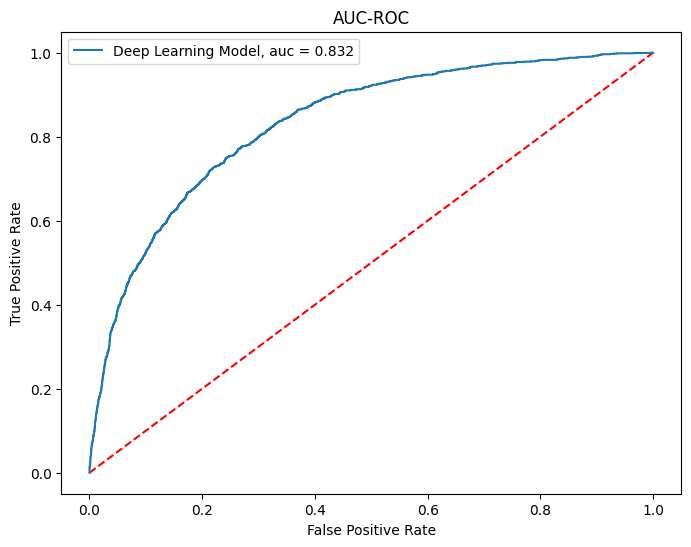

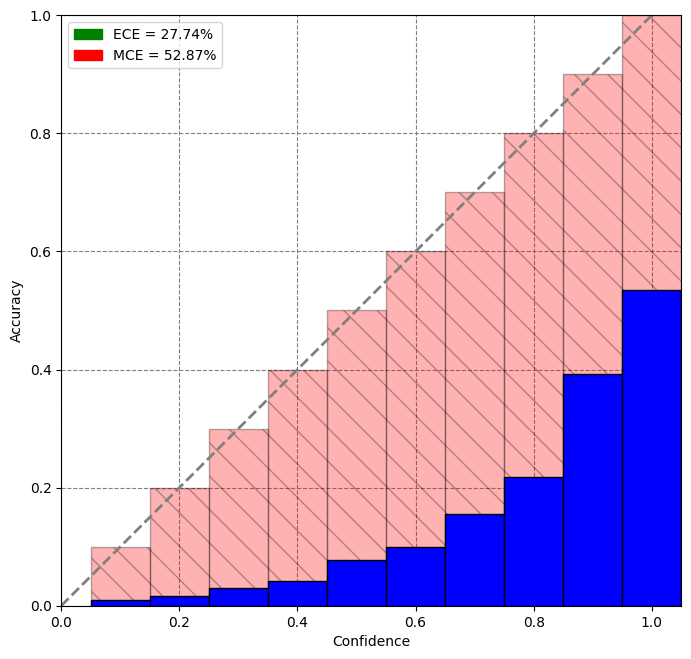

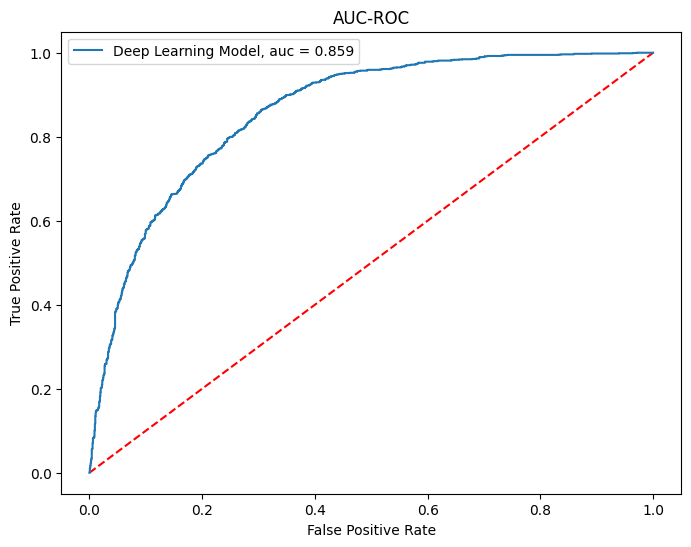

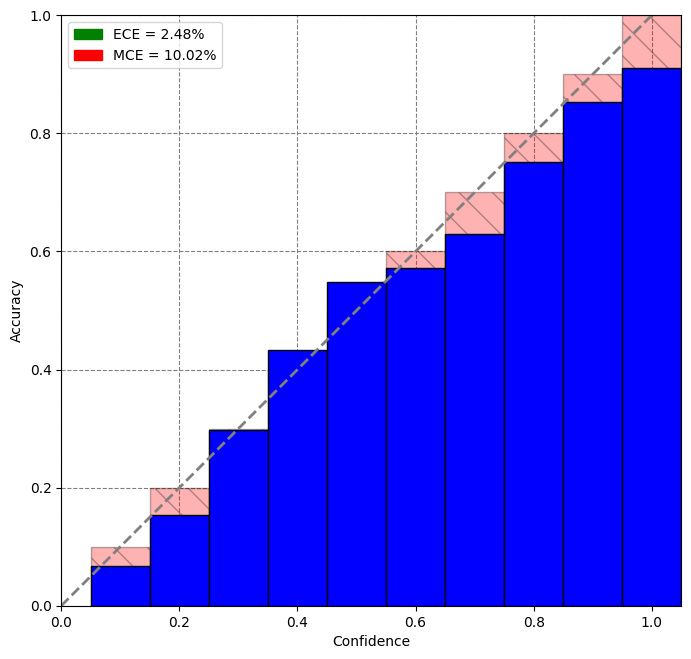

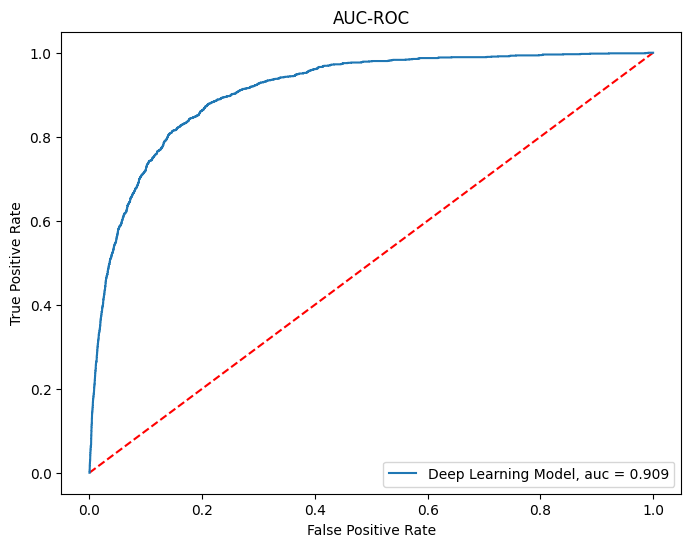

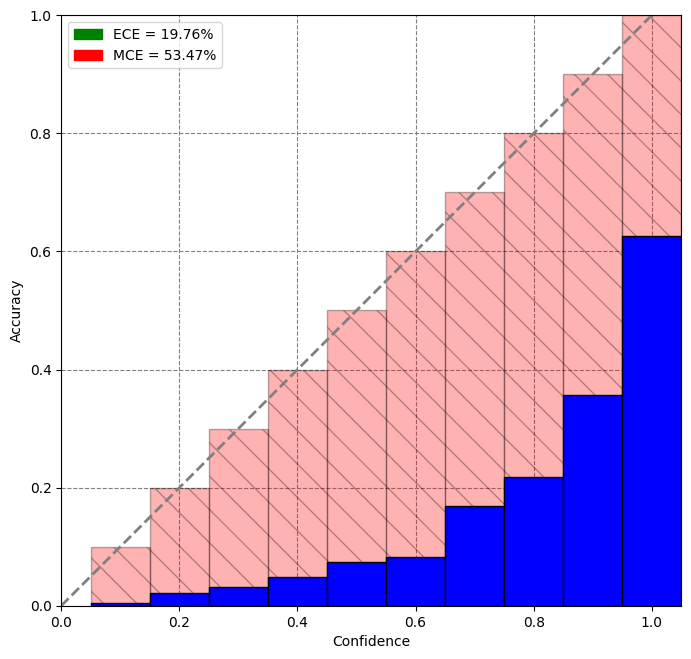

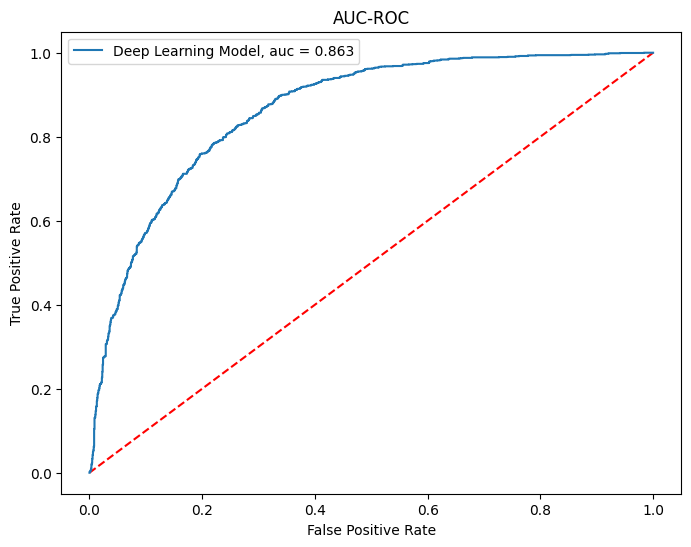

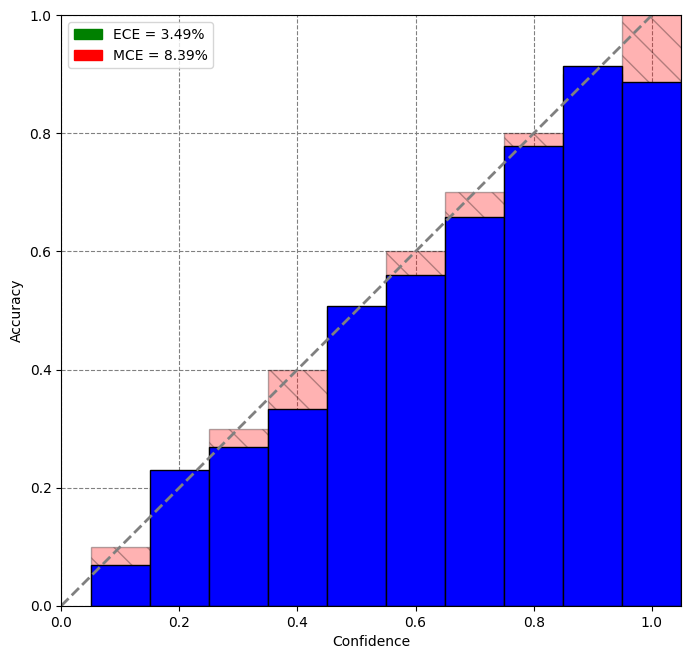

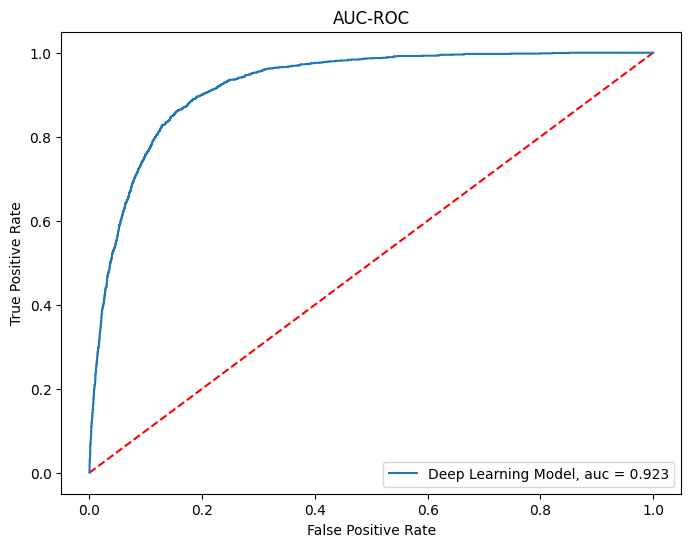

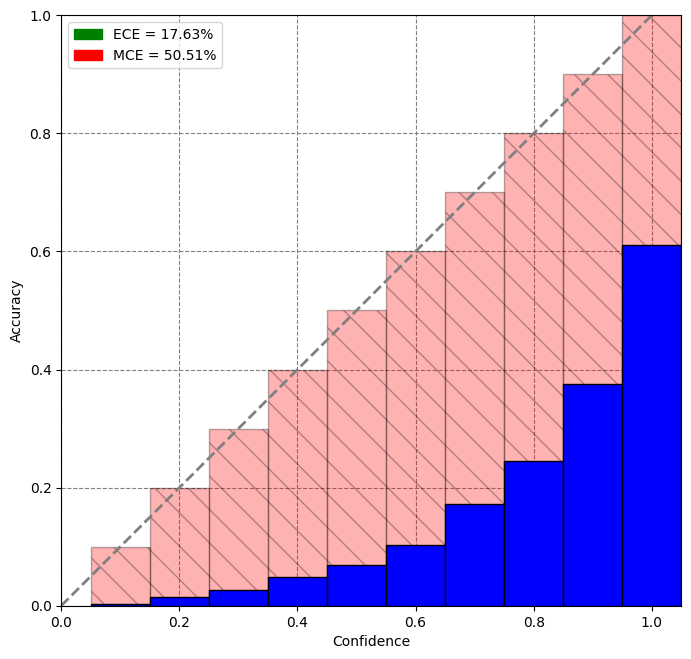

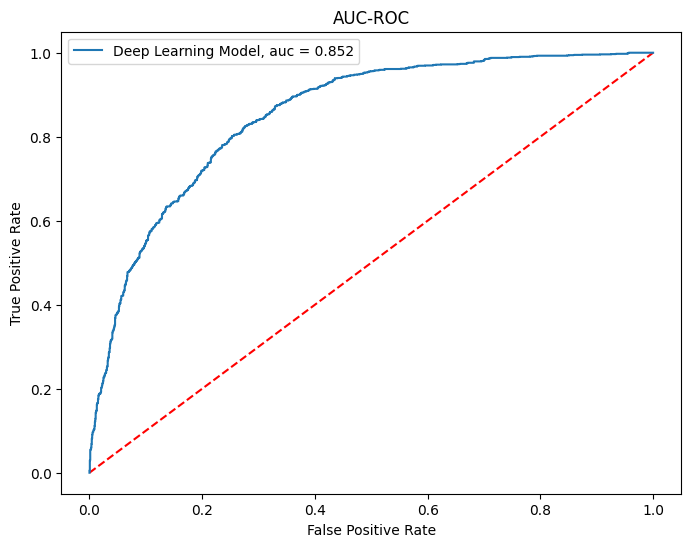

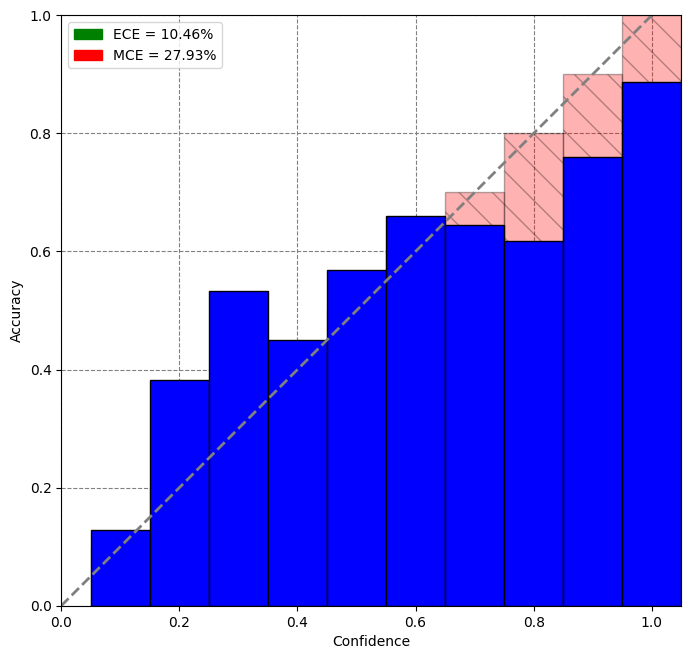

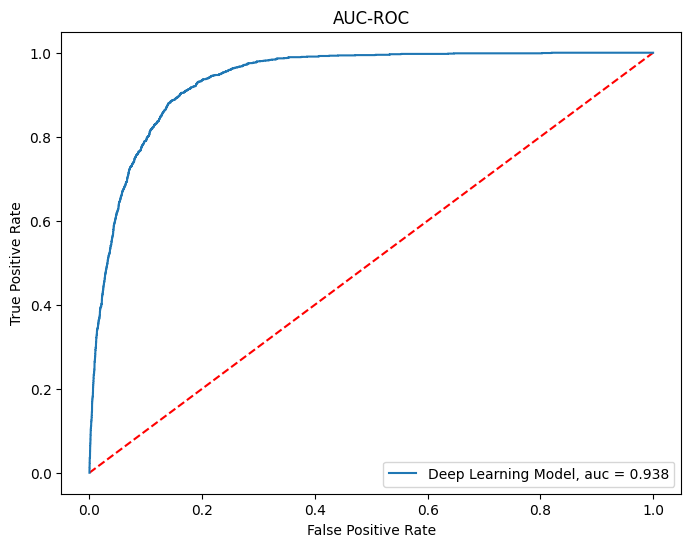

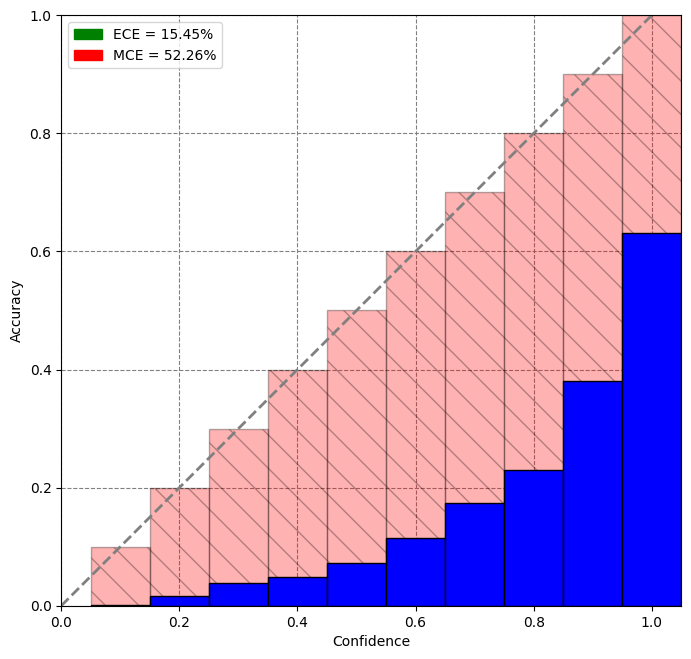

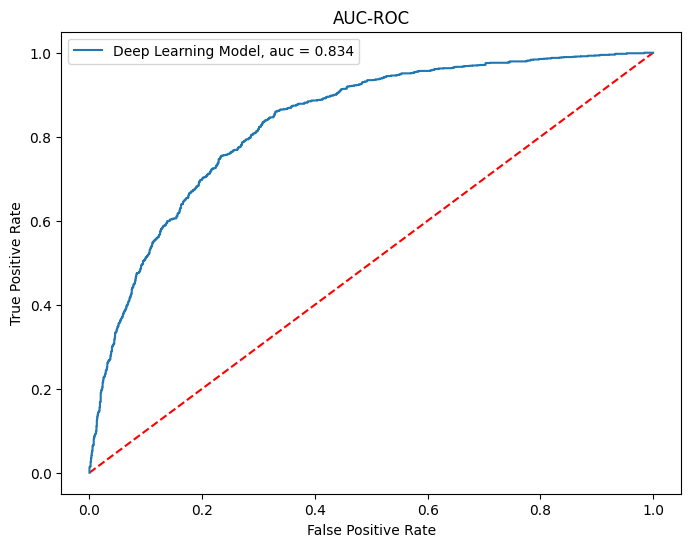

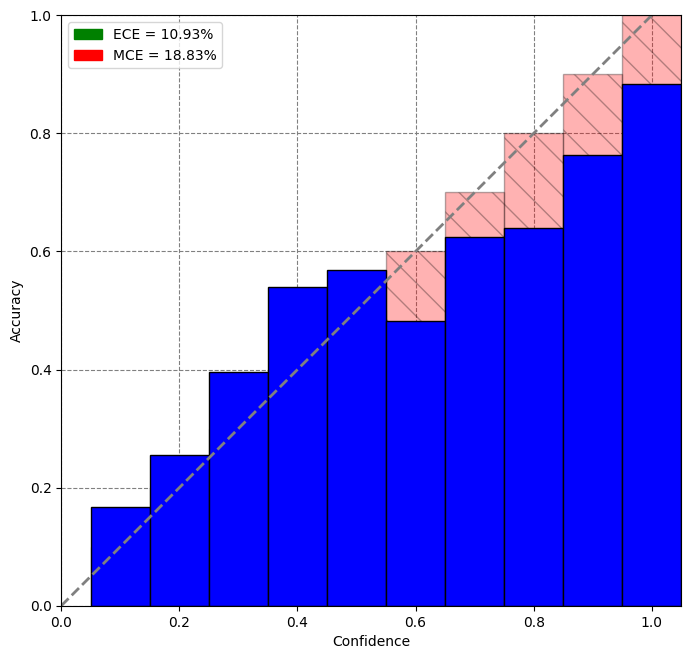

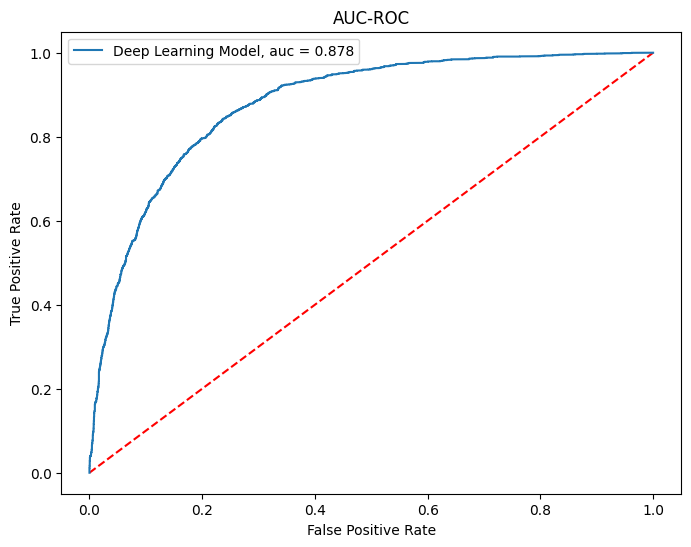

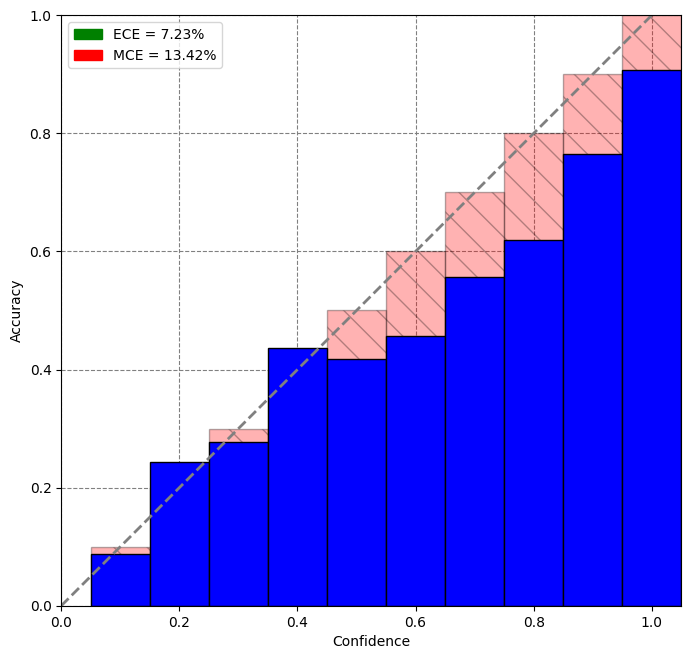

In [8]:
if radio_input7.value=='No CV':
    cv=0
elif radio_input7.value=='5-fold CV':
    cv=int(5)
elif radio_input7.value=='10-fold CV':
    cv=int(10)
    
if data_icu:
    model=dl_train.DL_models(data_icu,diag_flag,proc_flag,out_flag,chart_flag,med_flag,False,radio_input6.value,cv,oversampling=radio_input8.value=='True',model_name='attn_icu_read',train=True)
else:
    model=dl_train.DL_models(data_icu,diag_flag,proc_flag,False,False,med_flag,lab_flag,radio_input6.value,cv,oversampling=radio_input8.value=='True',model_name='attn_icu_read',train=True)

### 2. BEHRT
Below we integrate the implementation of BEHRT in our pipeline.
We perform pre-procesing needed to run BEHRT model. https://github.com/deepmedicine/BEHRT

Few things to note before running BEHRT -
- The numerical values are binned into quantiles.
- BEHRT has recommended maximum number of events per sample to be 512. 
    So feature selection is important so that number of events per sample does not exceed 512.
- The model is quite computationally heavy so it requires a GPU.

The output files for BEHRT will be saved in ./data/behrt/ folder

**Please run below cell to to pre-process and run BEHRT on the selected cohort**

## NOTE: CANNOT run BEHRT on most local machines. Cluster ONLY. 

In [9]:
if data_icu:
    token=tokenization.BEHRT_models(data_icu,diag_flag,proc_flag,out_flag,chart_flag,med_flag,False)
    tokenized_src, tokenized_age, tokenized_gender, tokenized_ethni, tokenized_ins, tokenized_labels=token.tokenize()
else:
    token=tokenization.BEHRT_models(data_icu,diag_flag,proc_flag,False,False,med_flag,lab_flag)
    tokenized_src, tokenized_age, tokenized_gender, tokenized_ethni, tokenized_ins, tokenized_labels=token.tokenize()
    
behrt_train.train_behrt(tokenized_src, tokenized_age, tokenized_gender, tokenized_ethni, tokenized_ins, tokenized_labels)

STARTING READING FILES.


 22%|███████████▍                                         | 4808/22354 [02:21<08:37, 33.88it/s]


KeyboardInterrupt: 

### EVALUATION AS STANDALONE MODULE
Below cell shows an exaple of how evaluation module can be used as a standalone module.

evaluation.Loss class can be instantiated and model output and ground truth can be passed to it to obtain results.

In the example below we captured model output and ground truth in a file and used that file to read the data.

In function definition ***loss(prob,truth,logits,False)***

prob -> List of Output predicted probabilities of case being positive

truth -> List of ground truth labels

logits -> List of logits obtained from last fully connected layer before applying softmax.sigmoid function in the model.

======= TESTING ========
BCE Loss: 0.96
AU-ROC: 0.88
AU-PRC: 0.86
AU-PRC Baaseline: 0.50
Accuracy: 0.80
Precision: 0.76
Recall: 0.87
Specificity: 0.73
NPV: 0.85
ECE: 0.07
MCE: 0.13


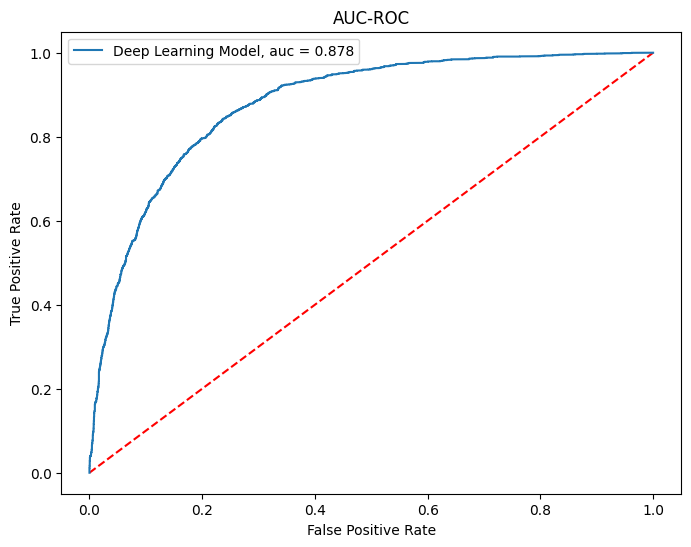

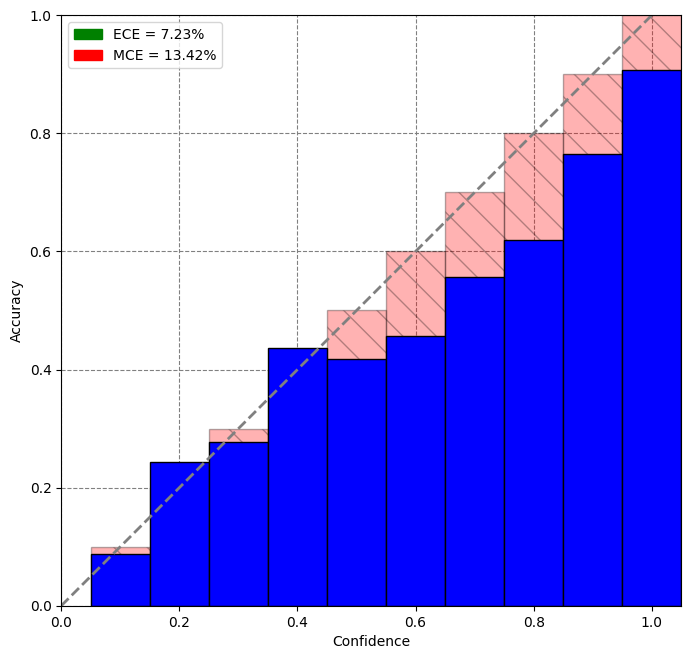

In [10]:
if torch.cuda.is_available():
    device='cuda:0'
#device='cpu'
loss=evaluation.Loss(device,acc=True,ppv=True,sensi=True,tnr=True,npv=True,auroc=True,aurocPlot=True,auprc=True,auprcPlot=True,callb=True,callbPlot=True)
with open("./data/output/outputDict", 'rb') as fp:
    outputDict=pickle.load(fp)
prob=list(outputDict['Prob'])
truth=list(outputDict['Labels'])
logits=list(outputDict['Logits'])
#print(torch.tensor(prob))
print("======= TESTING ========")
loss(prob,truth,logits,train=False,standalone=True)


### FAIRNESS EVALUATION
In train and testing step we save output files in **./data/output/** folder.

This file conatins list of demographic variables included in training and testing of the model.

It also contains the ground truth labels and predicted probability for each sample.

We use the above saved data to perform fairness evaluation of the results obtained from model testing.

This module can be used as stand-alone module also.

Please create a file that contains predicted probabilites form the last sigmoid layer in column named **Prob** and
ground truth labels for each sample in column named **Labels**.

In [11]:
fairness.fairness_evaluation(inputFile='outputDict',outputFile='fairnessReport')

,sensitive_attribute,group,tp,tn,fp,fn,tpr,tnr,fpr,fnr,pr,nr,accuracy
0,ethnicity,AMERICAN INDIAN/ALASKA NATIVE,5,6,3,0,1.000000,0.666667,0.333333,0.000000,0.571429,0.428571,0.785714
1,ethnicity,ASIAN,42,36,8,9,0.823529,0.818182,0.181818,0.176471,0.526316,0.473684,0.821053
2,ethnicity,ASIAN - ASIAN INDIAN,7,3,2,0,1.000000,0.600000,0.400000,0.000000,0.750000,0.250000,0.833333
3,ethnicity,ASIAN - CHINESE,27,26,7,1,0.964286,0.787879,0.212121,0.035714,0.557377,0.442623,0.868852
4,ethnicity,ASIAN - KOREAN,4,3,1,1,0.800000,0.750000,0.250000,0.200000,0.555556,0.444444,0.777778
5,ethnicity,ASIAN - SOUTH EAST ASIAN,16,10,2,1,0.941176,0.833333,0.166667,0.058824,0.620690,0.379310,0.896552
6,ethnicity,BLACK/AFRICAN,11,18,6,0,1.000000,0.750000,0.250000,0.000000,0.485714,0.514286,0.828571
7,ethnicity,BLACK/AFRICAN AMERICAN,274,255,87,45,0.858934,0.745614,0.254386,0.141066,0.546142,0.453858,0.800303
8,ethnicity,BLACK/CAPE VERDEAN,13,24,3,0,1.000000,0.888889,0.111111,0.000000,0.400000,0.600000,0.925000
9,ethnicity,BLACK/CARIBBEAN ISLAND,20,13,5,0,1.000000,0.722222,0.277778,0.000000,0.657895,0.342105,0.868421


### MODEL CALLIBRATION

Please run below cell if you want to callibrate predicted probabilites of the model on test data.
It will use the output saved during the testing of the model.

The file is saved in **./data/output/**.

This module can be used as stand-alone module also.

Please create a file that contain predicted logits form the last fully connected layer in column named **Logits** and <br>ground truth labels for each sample in a column named **Labels**.

BEFORE CALLIBRATION
BCE Loss: 0.96
AU-ROC: 0.88
AU-PRC: 0.86
AU-PRC Baaseline: 0.50
Accuracy: 0.80
Precision: 0.76
Recall: 0.87
Specificity: 0.73
NPV: 0.85
ECE: 0.07
MCE: 0.13
AFTER CALLIBRATION
BCE Loss: 0.88
AU-ROC: 0.88
AU-PRC: 0.86
AU-PRC Baaseline: 0.50
Accuracy: 0.80
Precision: 0.76
Recall: 0.87
Specificity: 0.73
NPV: 0.85
ECE: 0.03
MCE: 0.06


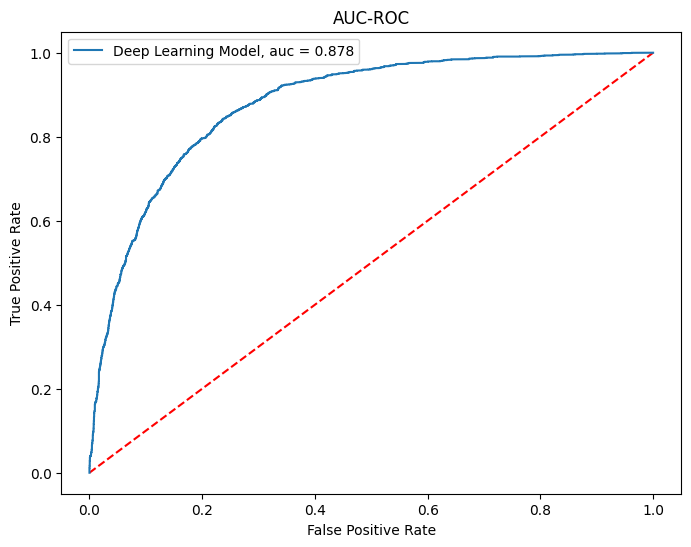

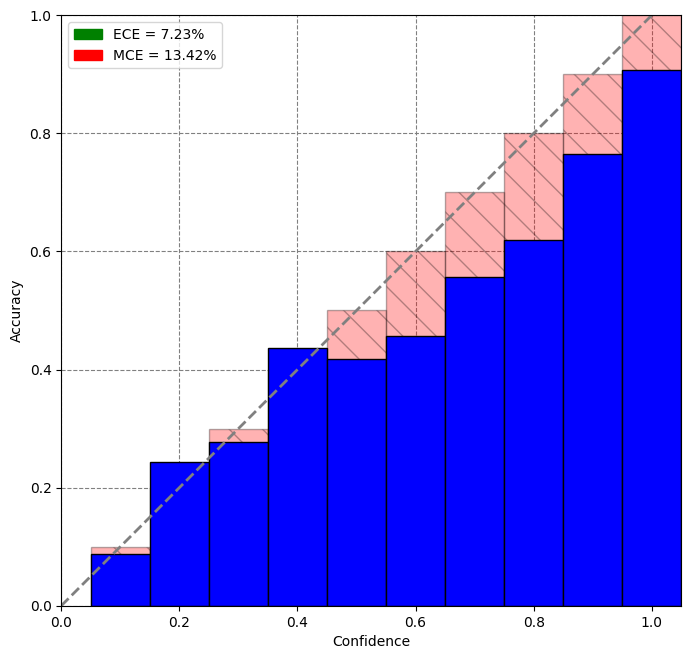

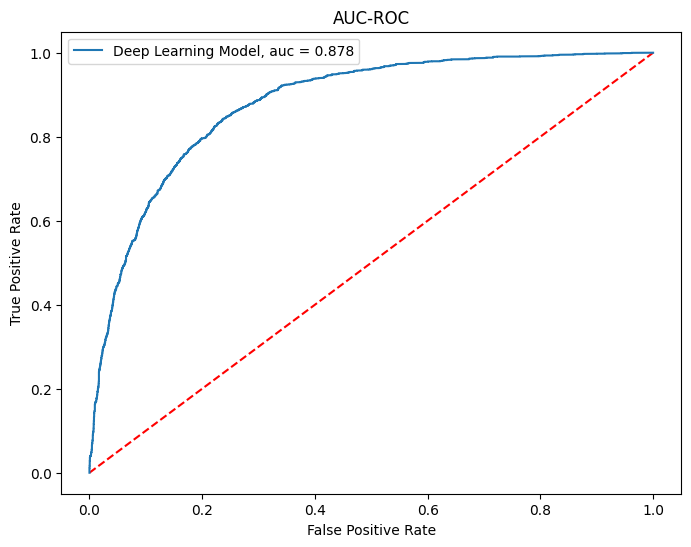

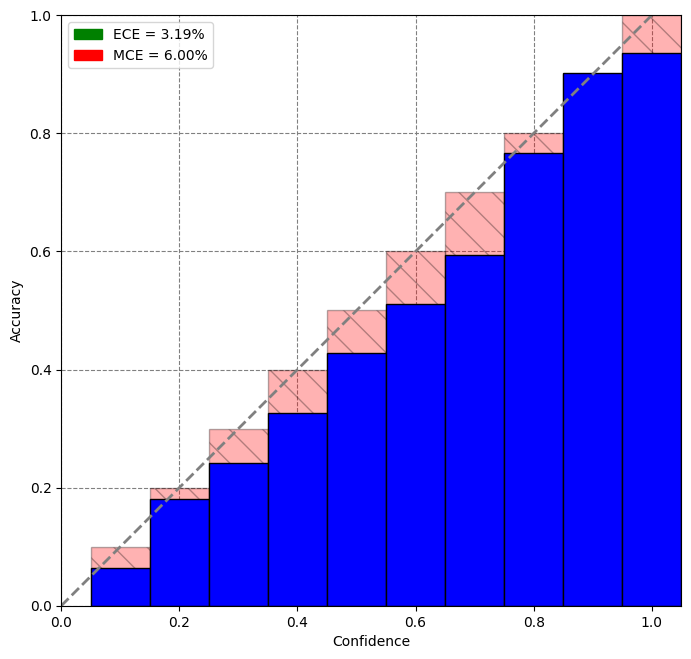

In [12]:
callibrate_output.callibrate(inputFile='outputDict',outputFile='callibratedResults')